# Trainable topo solvers

In this tutorial you learn how to
- use different data preprocessings
- use neural networks for topology optimization
- train and evaluate different models
- use our UNets
- apply equivariance to a neural network

If you want to use neural networks for topology optimization, then not much changes from the basic that we saw in the last tutorial. The main difference is of course that we need a neural network. Furthermore, we need to specify how we want to make our inputs - the TO problems - neural network compatible.

### Preprocessings

Choosing a suitable input preprocessing strategy is crucial for DL. We now present the two main preprocessings that we recommend you to use [1].
1. Trivial preprocessing. The input of the neural network is a 7-channel tensor which results from the channel-wise concatenation of Dirichlet boundary conditions $\Omega_\text{Dirichlet}$, design space information $\Omega_\text{design}$ and loads $F$. Additionally, it is possible to normalize each sample’s $F$ via the mean $\|F\|_∞$ over all training samples. This is arguably the most straightforward and intuitive type of preprocessing for learned end-to-end TO.
2. PDE preprocessing. We compute the von Mises stresses for the trivial solution. We normalize the resulting tensor with $20\%$ of the yield stress to obtain outputs that are likely close to the unit interval. These initial von Mises stresses are then used as a $1$-channel input to the neural network. It is also possible to use the displacements $u$ as input, or a concatenation of $u$ and $\sigma_{vM}$. We found that using the von Mises stresses $\sigma_{vM}$ is usually enough.

We will present both preprocessings in a bit more detail below.

Let's load the disc simple SELTO datasets for training and validation and take one example sample from the validation dataset:

In [ ]:
#ignore
from dl4to.datasets import SELTODataset

dataset_train = SELTODataset("/localdata/dl4to_dataset", name="disc_simple", train=True)
dataset_val = SELTODataset("/localdata/dl4to_dataset", name="disc_simple", train=False)

problem, gt_solution = dataset_val[0]

Found 1509 files.
importing dataset...


  0%|          | 0/1509 [00:00<?, ?it/s]

done!
Found 200 files.
importing dataset...


  0%|          | 0/200 [00:00<?, ?it/s]

done!


Next, we define dataloaders for both datasets:

In [ ]:
#ignore
from dl4to.utils import get_dataloader

dataloader_train = get_dataloader(dataset_train, batch_size=128)
dataloader_val = get_dataloader(dataset_val, batch_size=1)

#### Trivial preprocessing

We start out with the trivial preprocessing, which simply concatenates all problem-specific tensors. For that reason, trivial preprocessing is an example of what is called a "problem preprocessing". First, we initialize the preprocessing and check if it outputs the correct shape for our example sample.

In [ ]:
#ignore
from dl4to.preprocessing import TrivialPreprocessing

preprocessing = TrivialPreprocessing()
preprocessed_problem = preprocessing(problem)

preprocessed_problem.shape

torch.Size([1, 7, 39, 39, 4])

Indeed, the output is a 7-channel tensor, which is correct. We now check that the preprocessed problem is in fact just a channel-wise concatenation of the three problem tensors:

In [ ]:
#ignore
import torch

assert torch.all(preprocessed_problem[0,:3] == problem.Ω_dirichlet)
assert torch.all(preprocessed_problem[0,3] == problem.Ω_design)
assert torch.all(preprocessed_problem[0,4:] == problem.F)

There is one problem that makes this preprocessing difficult to use: The forces $F$ are not normalized, which leads entries in the preprocessed problem that are very large in magnitude:

In [ ]:
#ignore
preprocessed_problem.min(), preprocessed_problem.max()

(tensor(-3.0529e+09), tensor(1.5706e+10))

We can solve this problem by passing over "normalize=True" as an argument in the preprocessing initialization. As described above, this normalizes each sample’s $F$ via the mean $\|F\|_∞$ over all training samples. Therefore, we need to also pass over the dataset based on which we want to normalize the forces $F$.

In [ ]:
#ignore
preprocessing = TrivialPreprocessing(normalize=True, dataset=dataset_train)
preprocessed_problem = preprocessing(problem)
preprocessed_problem.min(), preprocessed_problem.max()

(tensor(-1.), tensor(1.))

We see that the normalization works and the values are now all within the $[-1,1]$ interval.

#### PDE Preprocessing

Next, we will preprocess our data with PDE preprocessing, i.e., the input for our neural network are the von Mises stresses of the trivial solution. The idea behind this is that the main loading paths inside of the material will be visible. PDE preprocessing is what we call a "solution preprocessing", because it works with solution objects.


For this preprocessing we need to attach a PDE solver to each problem that we apply it to.

In [ ]:
#ignore
from dl4to.pde import FDM
from dl4to.preprocessing import PDEPreprocessing

preprocessing = PDEPreprocessing(normalize=True)
problem.pde_solver = FDM()
preprocessed_problem = preprocessing(problem)

preprocessed_problem.shape

torch.Size([1, 1, 39, 39, 4])

As we see the preprocessed tensor is indeed a $1$-channel tensor. 
Note that it is not recommended to use this preprocessing alone. However, it can easily be combined with trivial preprocessing, which would return a tensor with $7+1=8$ channels. The preprocessings can be concatenated by summing them up:

In [ ]:
#ignore
preprocessing = TrivialPreprocessing() + PDEPreprocessing()

In order to apply PDE preprocessing to a dataset each problem needs to have a PDE solver attached to it. In the constructor of our SELTO datasets there is a flag "solve_pde_for_trivial_solution" which defaults to "False". If you set this flag to "True", then each problem will get an FDM solver attached to it. Additionally, the PDE is solved for each trivial solution and the PDE solution is saved in the object. This avoids that it needs to be re-computed at each run. Since the construction of the SELTO datasets with "solve_pde_for_trivial_solution=True" takes quite some time, we will use only trivial preprocessing for the following examples.

### Implement a supervised trainable topo solver

As stated previously, we will consider (normalized) trivial preprocessing from now on:

In [ ]:
#ignore
preprocessing = TrivialPreprocessing(normalize=True, dataset=dataset_train)

For the trainable topo solver we can use any network we want, as long as it is fully differentiable in PyTorch and the number of input and output channels are correct ("preprocessing.shape" as input and $1$ as output). Since the output should be interpretable as densities we also need to make sure that it only contains values between $0$ and $1$, e.g., by using a sigmoid activation after the last layer.

We start off with a very simple network which is only a 3d convolution with a sigmoid activation function. Further, we move the network to the GPU, which accelerates the training process:

In [ ]:
#ignore
model = torch.nn.Sequential(
    torch.nn.Conv3d(in_channels=preprocessing.shape, 
                        out_channels=1, 
                        kernel_size=3, 
                        padding=1),
    torch.nn.Sigmoid()
).to('cuda')

For our optimization criterion we choose the weighted binary cross entropy (BCE), where the purpose of the weightening is to consider class imbalances. 
We set the optimal weight based on the ground truth solutions in the training dataset:

In [ ]:
#ignore
from dl4to.criteria import WeightedBCE

criterion = WeightedBCE()
criterion.set_optimal_weight(dataset_train)

Setting criterion weight to 0.852246880531311.


A weight of $0.85$ means that $85\%$ of the voxels in the ground truth solutions of the training dataset have a density of $0$s. Note that BCE is a learning criterion that requires ground truth, i.e., it is only useful for supervised learning. You can also choose any other one of our criteria or implement your own, including unsupervised criteria. Any criterion in our framework can be used for training as well as an evaluation metric.

As our optimizer we choose Adam with a learning rate of $10^{-3}$ . We now have everything we need to initialize our trainable topo solver:

In [ ]:
#ignore
from dl4to.topo_solvers import TrainableTopoSolver
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

topo_solver = TrainableTopoSolver(criterion=criterion,
                                  model=model,
                                  optimizer=optimizer,
                                  preprocessing=preprocessing)

### Run training and validation

Now that we have initialized our topo solver, we can finally train it! For the sake of brevity we will only train for $50$ epochs.

Train epoch: 0. Train loss: 0.54±0.024.
Valid epoch: 0. Valid loss: 0.5±0.0044.
Train epoch: 10. Train loss: 0.27±0.02.
Valid epoch: 10. Valid loss: 0.27±0.019.
Train epoch: 20. Train loss: 0.26±0.023.
Valid epoch: 20. Valid loss: 0.26±0.022.
Train epoch: 30. Train loss: 0.26±0.023.
Valid epoch: 30. Valid loss: 0.26±0.022.
Train epoch: 40. Train loss: 0.26±0.022.
Valid epoch: 40. Valid loss: 0.25±0.021.
Train epoch: 49. Train loss: 0.25±0.022.
Valid epoch: 49. Valid loss: 0.25±0.021.


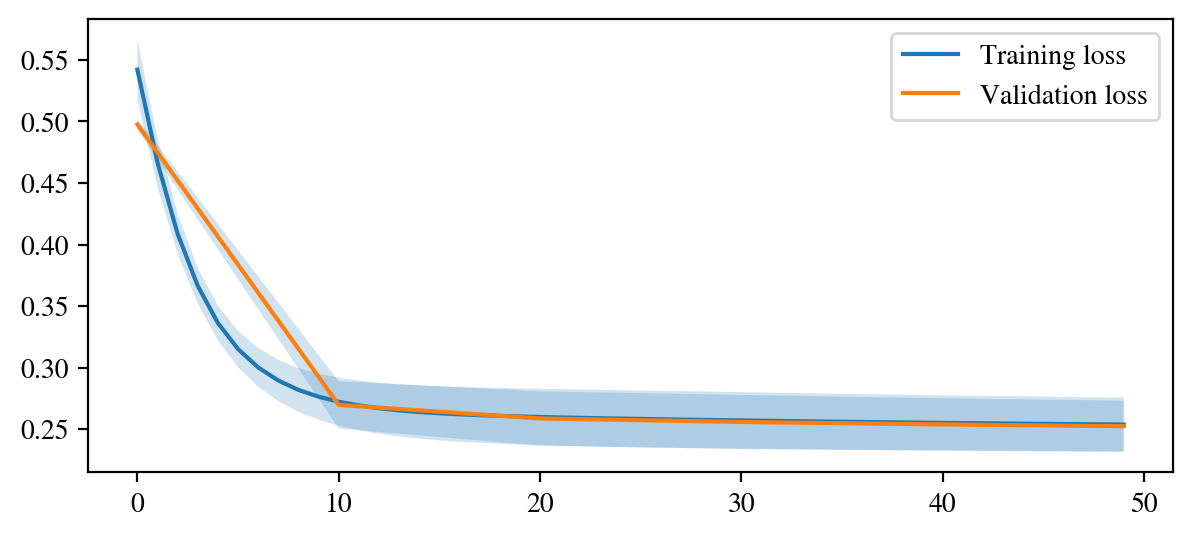

Finished training after 50 epochs.



In [ ]:
#ignore
topo_solver.train(
        root='training/cnn',
        epochs=50,
        dataloader_train=dataloader_train,
        dataloader_val=dataloader_val,
        validation_interval=10
)

Let's evaluate the performance of our trained model with some evaluation criteria. We will use the Intersection over Union (IoU) score and the Dice score. Both of them are typical metrics for binary segmentation tasks.

In [ ]:
#ignore
from dl4to.criteria import IoU, Dice

criteria = [IoU(), Dice()]

logs = topo_solver.eval(
        root='training/cnn',
        criteria=criteria,
        dataloader=dataloader_val,
    )

The training and validation logs are both automatically saved in the specified root directory. The `logs['IoU']` file contains the IoU scores for the final model for all individual samples from the validation dataset. In order to obtain the average score we need to average over all of them:

In [ ]:
#ignore
print("IoU:", sum(logs['IoU']) / len(logs['IoU']))
print("Dice:", sum(logs['Dice']) / len(logs['Dice']))

IoU: 0.0009501588309649378
Dice: 0.9981135129928589


IoU and Dice are both metrics that return values in the unit interval. High IoU scores and low Dice scores are good, so these results are pretty bad!

Let's check how the outputted solution for our example sample from the validation dataset looks. We plot with a threshold of $0.5$ so that we can better see the structure:

In [ ]:
#ignore
solution = topo_solver(problem)
camera_position = [0,0.02,0.12]
solution.plot(threshold=.5, 
              camera_position=camera_position,
              display=False)

![cnn_density](https://dl4to.github.io/dl4to/images/4_cnn_density.png)

This also does not look good at all, but our model is also very small. It seems we need a more powerful model for better results.

### Training and evaluating a UNet

Our library comes with some useful model architectures that you use. One of them is a 3D UNet and it is the same that we also used in our SELTO paper [1]. The UNet is a convolutional autoencoder model, that consists of one encoding and one decoding branch. Note that for the disc dataset we choose a pooling kernel size of $[2,2,1]$, i.e. we perform no pooling in $z$ direction. This is due to the low number of voxels in that dimension.

In [ ]:
#ignore
from dl4to.models import UNet3D

model = UNet3D(in_channels=preprocessing.shape, pooling_kernel_size=[2,2,1]).to('cuda')

Built model with 1596361 parameters.


Train epoch: 0. Train loss: 0.51±0.078.
Valid epoch: 0. Valid loss: 0.55±0.0018.
Train epoch: 10. Train loss: 0.21±0.013.
Valid epoch: 10. Valid loss: 0.21±0.016.
Train epoch: 20. Train loss: 0.1±0.015.
Valid epoch: 20. Valid loss: 0.12±0.014.
Train epoch: 30. Train loss: 0.06±0.013.
Valid epoch: 30. Valid loss: 0.062±0.014.
Train epoch: 40. Train loss: 0.043±0.012.
Valid epoch: 40. Valid loss: 0.049±0.017.
Train epoch: 49. Train loss: 0.037±0.013.
Valid epoch: 49. Valid loss: 0.045±0.015.


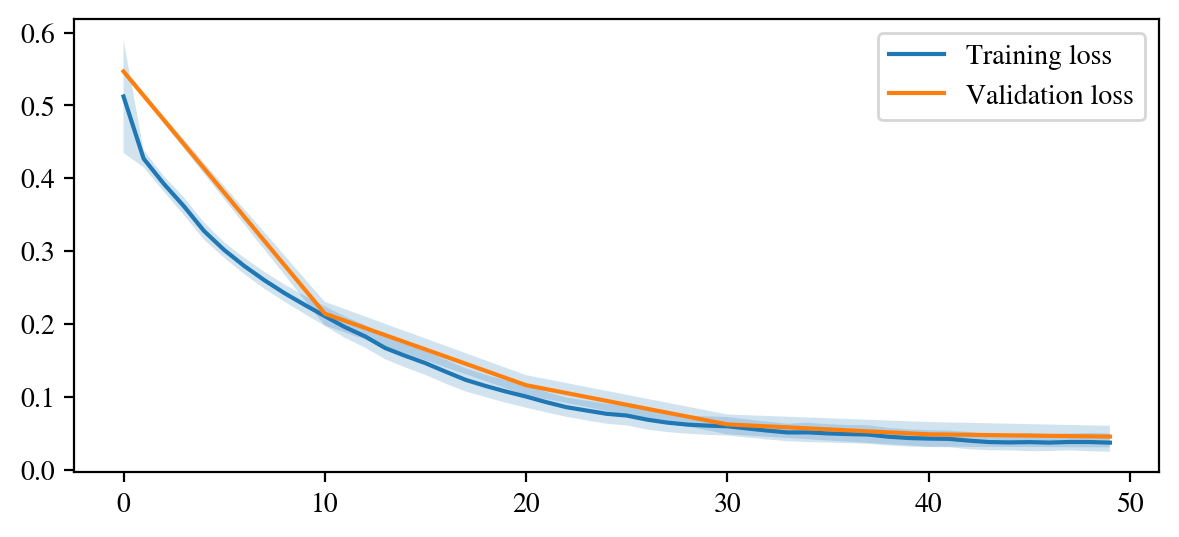

Finished training after 50 epochs.



In [ ]:
#ignore
optimizer = Adam(model.parameters(), lr=1e-3)
topo_solver = TrainableTopoSolver(criterion=criterion,
                                  model=model,
                                  optimizer=optimizer,
                                  preprocessing=preprocessing)

topo_solver.train(
        root='training/unet',
        epochs=50,
        dataloader_train=dataloader_train,
        dataloader_val=dataloader_val,
        validation_interval=10
)

In [ ]:
#ignore
logs = topo_solver.eval(
        root='training/unet',
        criteria=criteria,
        dataloader=dataloader_val,
    )

print("IoU:", sum(logs['IoU']) / len(logs['IoU']))
print("Dice:", sum(logs['Dice']) / len(logs['Dice']))

IoU: 0.8020480927824974
Dice: 0.11157194912433624


Now this looks far better than the previous model. Let's take a look at our example sample:

In [ ]:
#ignore
solution = topo_solver(problem)
solution.plot(threshold=.5, 
              camera_position=camera_position,
              display=False)

![unet_density](https://dl4to.github.io/dl4to/images/4_unet_density.png)

This is the ground truth for comparison:

In [ ]:
#ignore
gt_solution.plot(camera_position=camera_position,
                 display=False)

![gt_density](https://dl4to.github.io/dl4to/images/4_gt_density.png)

### Adding Equivariance

We can further improve our model by including rotational and mirror equivariance.

Equivariance is the property of a function to commute with the actions of a symmetry group. For a given transformation group $G$, a function $f:X\rightarrow Y$ is ($G$-)equivariant if $f(T^X_g(x)) = T^Y_g(f(x))$ for all $g\in G, \, x\in X,$ where $T^{X}_g$ and $T^{Y}_g$ denote linear group actions in the corresponding spaces $X$ and $Y$. As shown in our paper [1], mirror and rotation equivariance can drastically improve model performance on TO tasks. We implement equivariance via group averaging [2] by defining an equivariance wrapper $F_G^f$ via $F_G^f(x) := \frac{1}{| G|} \sum_{g\in G} T_{g^{-1}}^Y \left[ f(T_g^X(x))\right].$
The plug-and-play nature of $F_G^f$ allows effortless applicability to any (finite) transformation group $G$ and any model $f$.

With our library it is very easy to make any model equivariant under rotations and mirrors. You only need to define an equivariance wrapper and call it with the (non-equivariant) PyTorch model:

In [ ]:
#ignore
from dl4to.models import UNet3D
from dl4to.models import EquivarianceWrapper

model = UNet3D(in_channels=preprocessing.shape, pooling_kernel_size=[2,2,1]).to('cuda')
equivariance_wrapper = EquivarianceWrapper(preprocessing=preprocessing)
model = equivariance_wrapper(model)

Built model with 1596361 parameters.


Equivariance is especially beneficial if you have very few training samples available. However, even here it should be able to improve model performance. Note that the training takes it bit longer because for backpropagation we need to propagate the gradients through all summands in the wrapper.

Train epoch: 0. Train loss: 0.39±0.05.
Valid epoch: 0. Valid loss: 0.35±0.0057.
Train epoch: 10. Train loss: 0.14±0.0091.
Valid epoch: 10. Valid loss: 0.14±0.015.
Train epoch: 20. Train loss: 0.054±0.012.
Valid epoch: 20. Valid loss: 0.056±0.014.
Train epoch: 30. Train loss: 0.037±0.011.
Valid epoch: 30. Valid loss: 0.037±0.01.
Train epoch: 40. Train loss: 0.029±0.01.
Valid epoch: 40. Valid loss: 0.029±0.011.
Train epoch: 49. Train loss: 0.028±0.011.
Valid epoch: 49. Valid loss: 0.029±0.01.


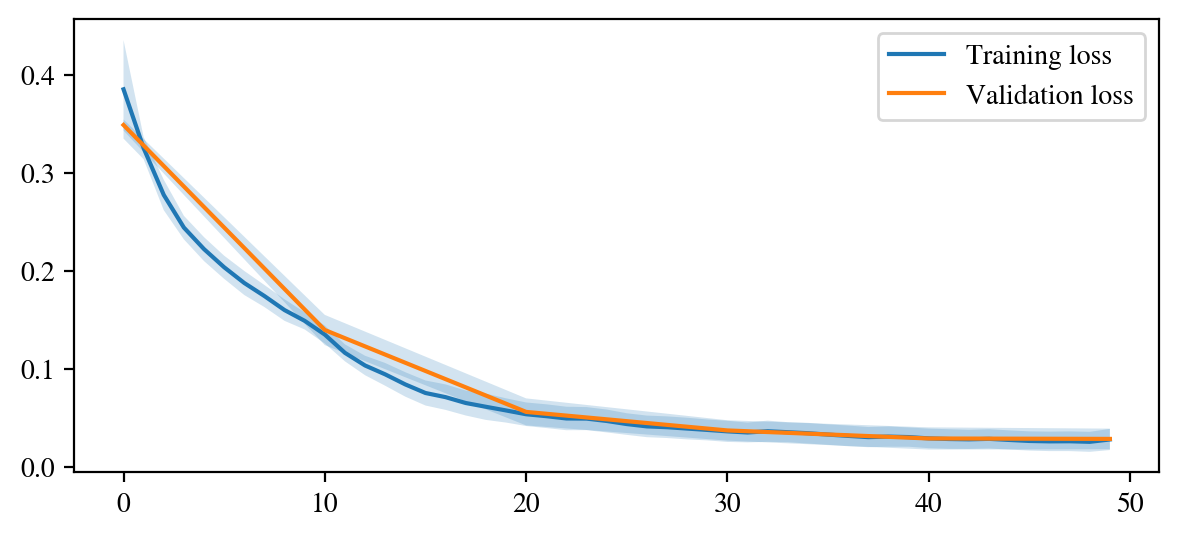

Finished training after 50 epochs.



In [ ]:
#ignore
optimizer = Adam(model.parameters(), lr=1e-3)
topo_solver = TrainableTopoSolver(criterion=criterion,
                                  model=model,
                                  optimizer=optimizer,
                                  preprocessing=preprocessing)

topo_solver.train(
        root='training/equiv_unet',
        epochs=50,
        dataloader_train=dataloader_train,
        dataloader_val=dataloader_val,
        validation_interval=10
)

In [ ]:
#ignore
logs = topo_solver.eval(
        root='training/equiv_unet',
        criteria=criteria,
        dataloader=dataloader_val,
    )

print("IoU:", sum(logs['IoU']) / len(logs['IoU']))
print("Dice:", sum(logs['Dice']) / len(logs['Dice']))

IoU: 0.8708449047803879
Dice: 0.0700238224864006


In [ ]:
#ignore
solution = topo_solver(problem)
solution.plot(threshold=.5, 
              camera_position=camera_position,
              display=False)

![eq_unet_density](https://dl4to.github.io/dl4to/images/4_eq_unet_density.png)

We see that the IoU and Dice score improved from the addition of equivariance. We could further improve performance by combining trivial and PDE preprocessing, as we showed in our SELTO paper [1].

### References

[1] Dittmer, Sören, et al. "SELTO: Sample-Efficient Learned Topology Optimization." arXiv preprint arXiv:2209.05098 (2022).

[2] Puny, Omri, et al. "Frame averaging for invariant and equivariant network design." arXiv preprint arXiv:2110.03336 (2021).